# Notebook 4: Sensitivity Analysis

**Objective:** To understand which parameters have the strongest influence on the stability of the full coexistence equilibrium (E3). We will perform a local sensitivity analysis by calculating how the real part of the dominant eigenvalue changes with respect to a small change in each parameter.

In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Add project root to path
if '..' not in sys.path:
    sys.path.append('..')

from config import get_params
from chemostat_analysis.equilibria import find_equilibria
from chemostat_analysis.stability import analyze_stability

/Users/xuanthanhnguyen/Library/CloudStorage/OneDrive-HanoiUniversityofScienceandTechnology/2024-1/Leftt/2024-2/Maths Modelling/code/chemostat_foodchain_analyzer/notebooks/../chemostat_analysis/equilibria.py:3: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  from scipy.optimize import fsolve, root_scalar


### Sensitivity Calculation

The sensitivity of the system's stability to a parameter `p` can be approximated by the finite difference:

$$ S_p = \\frac{\\Delta(\\text{Re}(\\lambda_{dom}))}{\\Delta p} \\approx \\frac{\\text{Re}(\\lambda_{dom}(p + \\delta p)) - \\text{Re}(\\lambda_{dom}(p))}{\\delta p} $$

where `λ_dom` is the eigenvalue with the largest real part. A large positive value of `S_p` means that increasing `p` strongly destabilizes the system. A large negative value means increasing `p` strongly stabilizes it.

In [2]:
params = get_params("truly_stable")

# Find the E3 equilibrium for this baseline
equilibria = find_equilibria(params)
E3_point = equilibria.get("E3")

if E3_point is None:
    print("E3 does not exist for the chosen baseline parameters. Cannot perform sensitivity analysis.")
else:
    # Calculate baseline stability
    base_eigs, base_stability = analyze_stability(E3_point, params)
    base_max_real = np.max(np.real(base_eigs))
    
    # --- Corrected print statement ---
    print(f"Baseline E3 found. Stability: {base_stability} (Max Re(λ) = {base_max_real:.4f})\n")

    sensitivities = {}
    delta_p_fraction = 0.01  # Perturb each parameter by 1%

    # Iterate over all parameters to test their sensitivity
    for param_name in tqdm(params.keys(), desc="Calculating Sensitivities"):
        perturbed_params = params.copy()
        delta_p = params[param_name] * delta_p_fraction
        if delta_p == 0:
            delta_p = 1e-5
        perturbed_params[param_name] += delta_p
        
        perturbed_equilibria = find_equilibria(perturbed_params)
        perturbed_E3 = perturbed_equilibria.get("E3")
        
        if perturbed_E3 is not None:
            perturbed_eigs, _ = analyze_stability(perturbed_E3, perturbed_params)
            perturbed_max_real = np.max(np.real(perturbed_eigs))
            
            sensitivity = (perturbed_max_real - base_max_real) / delta_p
            sensitivities[param_name] = sensitivity
        else:
            sensitivities[param_name] = np.nan

Baseline E3 found. Stability: Unstable (Saddle) (Max Re(λ) = 0.0514)



Calculating Sensitivities:   0%|          | 0/9 [00:00<?, ?it/s]

Sensitivity plot saved to: ../results/plots/sensitivity_analysis.png


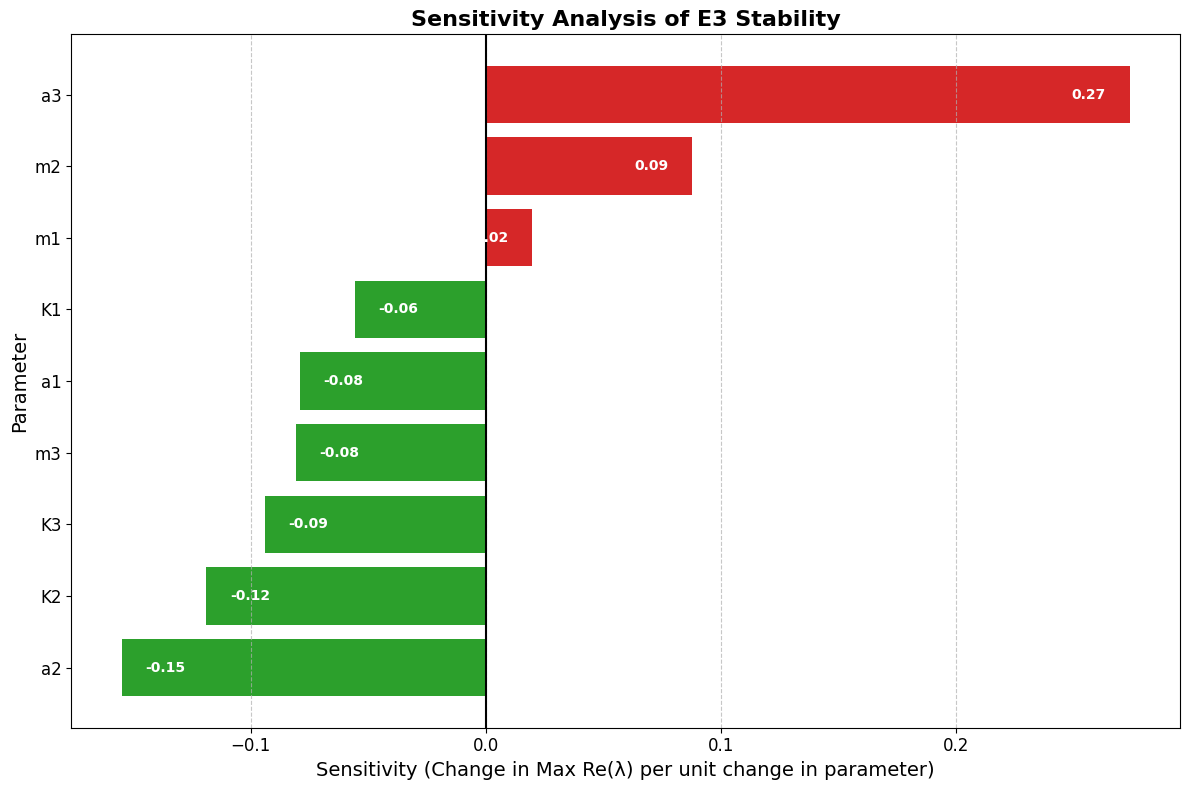

In [3]:
if 'sensitivities' in locals() and E3_point is not None:
    # Filter out any NaN values for plotting
    valid_sensitivities = {k: v for k, v in sensitivities.items() if not np.isnan(v)}
    
    # Sort sensitivities for better visualization
    sorted_sensitivities = sorted(valid_sensitivities.items(), key=lambda item: item[1])
    names = [item[0] for item in sorted_sensitivities]
    values = [item[1] for item in sorted_sensitivities]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['#d62728' if v > 0 else '#2ca02c' for v in values]  # Red for destabilizing, green for stabilizing
    
    bars = ax.barh(names, values, color=colors)
    ax.axvline(0, color='black', lw=1.5)
    
    ax.set_xlabel("Sensitivity (Change in Max Re(λ) per unit change in parameter)", fontsize=14)
    ax.set_ylabel("Parameter", fontsize=14)
    ax.set_title("Sensitivity Analysis of E3 Stability", fontsize=16, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add text labels to bars for clarity
    for bar in bars:
        width = bar.get_width()
        # Position label inside the bar
        x_pos = width - (0.01 * np.sign(width))
        ha = 'right' if width > 0 else 'left'
        ax.text(x_pos, bar.get_y() + bar.get_height()/2., f'{width:.2f}',
                va='center', ha=ha, color='white', fontweight='bold')
                
    plt.tight_layout()
    
    # Save the plot to the results folder
    save_path = '../results/plots/sensitivity_analysis.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Sensitivity plot saved to: {save_path}")
    
    plt.show()